# Description:

* number libraries = 1
* isotope incorp: 0% for all taxa (baseline)
* abundance distribution: lognormal

## Goals:

* assess how fragment length affects distribution of amplicon fragments
  * fragment distributions:
    * uniform, large range
    * uniform, all small fragments
    * uniform, all large fragments
    * skewed normal, 4 kb size cutoff
    * skewed normal, 0.5 kb size cutoff

# Init

In [95]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome_all/nl1/fragLen/'
baseDir = '/home/nick/notebook/SIPSim/dev/bac_genome_all/'
SIPSimExe = '/home/nick/notebook/SIPSim/SIPSim'

In [96]:
import os,sys
import numpy as np
import pandas as pd
from ggplot import *
import matplotlib.pyplot as plt

In [97]:
%load_ext rpy2.ipython
%matplotlib inline

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [98]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(data.table)

In [99]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Simulating gradient communities

In [22]:
!cd $workDir; \
    $SIPSimExe gradientComms \
    --abund_dist lognormal \
    --abund_dist_p mean:10,sigma:2 \
    $baseDir/genomes/taxon_index.txt > comm-n1-logn.txt

[1] 100
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000006 0.003088 0.010750 0.082640 0.040510 8.164000 
[1] 1392199


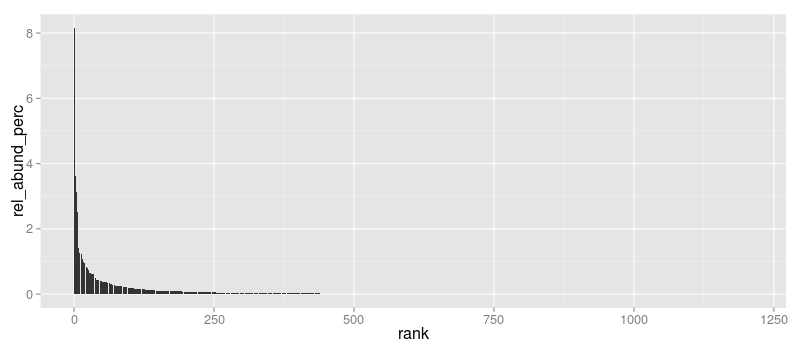

In [23]:
%%R -i workDir -w 800 -h 350 
# plotting the abundance distribution
setwd(workDir)

tbl = read.delim('comm-n1-logn.txt', sep='\t')

print(sum(tbl$rel_abund_perc))
print(summary(tbl$rel_abund_perc))
print(max(tbl$rel_abund_perc) / min(tbl$rel_abund_perc))

# plotting
ggplot(tbl, aes(rank, rel_abund_perc)) +
    geom_bar(stat='identity') +
    theme( text = element_text(size=16))

# Simulating isotope incorporation

In [24]:
# making config file
config = """
[library 1]
  # baseline: no incorp
  
  [[intraPopDist 1]]
  distribution = uniform
  weight = 1

    [[[start]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

    [[[end]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0
"""

outfile = os.path.join(workDir, 'incorp.config')

outf = open(outfile, 'wb')
outf.write(config)
outf.close()

In [25]:
!cd $workDir; \
     $SIPSimExe isoIncorp \
    comm-n1-logn.txt \
    incorp.config > incorp-n1-logn.txt

In [26]:
!cd $workDir; head incorp-n1-logn.txt

library	taxon_name	distribution_index	distribution	weight	param	param_value
1	Alcanivorax_borkumensis_SK2	1	uniform	1.0	start	4.8274712576e-07
1	Alcanivorax_borkumensis_SK2	1	uniform	1.0	end	4.40675237499e-06
1	Borrelia_bissettii_DN127	1	uniform	1.0	start	7.17711675035e-07
1	Borrelia_bissettii_DN127	1	uniform	1.0	end	5.2443190104e-06
1	Sphingomonas_sanxanigenens_DSM_19645_NX02	1	uniform	1.0	start	8.24100184785e-06
1	Sphingomonas_sanxanigenens_DSM_19645_NX02	1	uniform	1.0	end	4.47124622597e-06
1	Arcanobacterium_haemolyticum_DSM_20595	1	uniform	1.0	start	1.43744418299e-06
1	Arcanobacterium_haemolyticum_DSM_20595	1	uniform	1.0	end	1.60075355215e-06
1	Chlamydophila_felis_Fe_C-56	1	uniform	1.0	start	7.78934231318e-06


# Simulating gradient fractions

In [27]:
!cd $workDir; \
    $SIPSimExe fractions \
    comm-n1-logn.txt \
    > fracs-n1-logn.txt

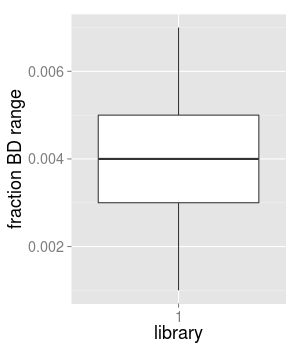

In [30]:
%%R -i workDir -h 350 -w 300 
# plotting the abundance distribution
setwd(workDir)

tbl = read.delim('fracs-n1-logn.txt', sep='\t')
tbl$library = as.character(tbl$library)


ggplot(tbl, aes(library, fraction_size)) +
    geom_boxplot() +
    labs(y='fraction BD range') +
    theme( 
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
    )

# Simulating amplicon fragments & calculating GC

## Uniform fragment length distribution: large range

* 10k amplicon-fragments per genome

In [65]:
!cd $workDir; \
    $SIPSimExe fragGC \
    $baseDir/genomes/genome_index.txt \
    --fp $baseDir/genomes/ \
    --fr $baseDir/515Fm-927Rm.fna \
    --fld uniform,500,15000 \
    --flr 500,None \
    --nf 10000 \
    --np 24 \
    2> ampFragGC_unif5-150.log \
    > ampFragGC_unif5-150.pkl

## Creating OTU table

In [ ]:
!cd $workDir; \
    $SIPSimExe OTU_sim \
    ampFragGC_unif5-150.pkl \
    comm-n1-logn.txt \
    incorp-n1-logn.txt \
    fracs-n1-logn.txt \
    --abs_abund 1e9 \
    2> OTU-n1-logn_unif5-150_A1e9.log \
    > OTU-n1-logn_unif5-150_A1e9.txt

## Plotting OTU table

In [64]:
%%R -i workDir

# loading file
infile = paste(c(workDir, 'OTU-n1-logn_unif5-150_A1e9.txt'), collapse='/')
tbl = read.csv(infile, sep='\t')

tbl = tbl %>% 
    separate(fractions, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%
    filter(BD_min != 1.795)

In [65]:
%%R

# summarizing counts (should be approx. total abundance)
tbl %>%
    group_by(library) %>%
    summarize(sum(count))  

Source: local data frame [1 x 2]

  library sum(count)
1       1  946848583


In [66]:
%%R

# summarizing counts (should be approx. total abundance)
tbl %>%
    group_by(BD_min) %>%
    summarize(sum(count)) %>% as.data.frame

   BD_min sum(count)
1   1.660      10768
2   1.664      41542
3   1.668      97472
4   1.671    1414599
5   1.678   11932048
6   1.684   19314994
7   1.687   44827516
8   1.691   99891610
9   1.696  154547601
10  1.701   75582064
11  1.704  103331951
12  1.710   53022597
13  1.713  100962026
14  1.718   43020550
15  1.720  152691828
16  1.727   57554042
17  1.731   14534870
18  1.733   12157882
19  1.738    1448377
20  1.742     341685
21  1.746     100268
22  1.751      16993
23  1.755       4133
24  1.759       1061
25  1.765         92
26  1.769         10
27  1.772          4
28  1.776          0
29  1.778          0
30  1.781          0
31  1.783          0
32  1.788          0
33  1.791          0
34  1.794          0


In [67]:
%%R
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

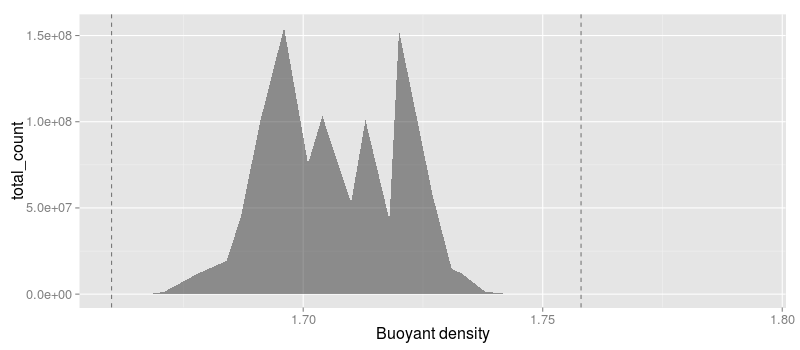

In [68]:
%%R -w 800 -h 350
# plotting absolute abundances

tbl.s = tbl %>%
    group_by(BD_min) %>%
    summarize(total_count = sum(count))


## plot
p = ggplot(tbl.s, aes(BD_min, total_count)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme( 
        text = element_text(size=16) 
    )
p

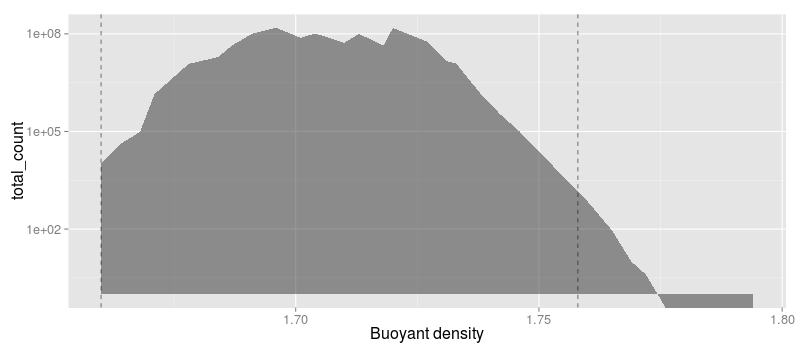

In [69]:
%%R -w 800 -h 350

p + scale_y_log10()

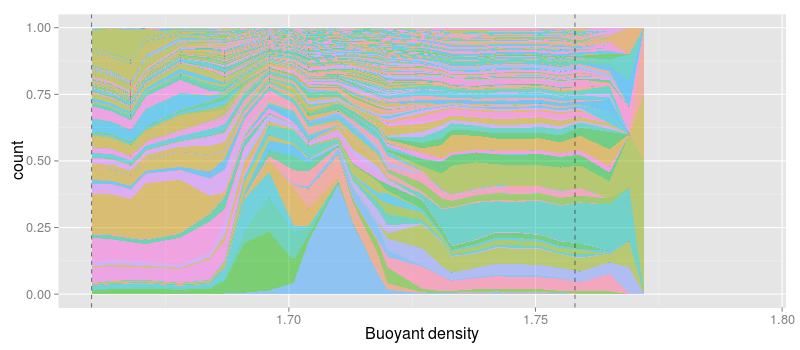

In [70]:
%%R -w 800 -h 350
# plotting relative abundances

## plot
p = ggplot(tbl, aes(BD_min, count, fill=taxon, group=taxon)) +
    geom_area(stat='identity', alpha=0.5, position='fill') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

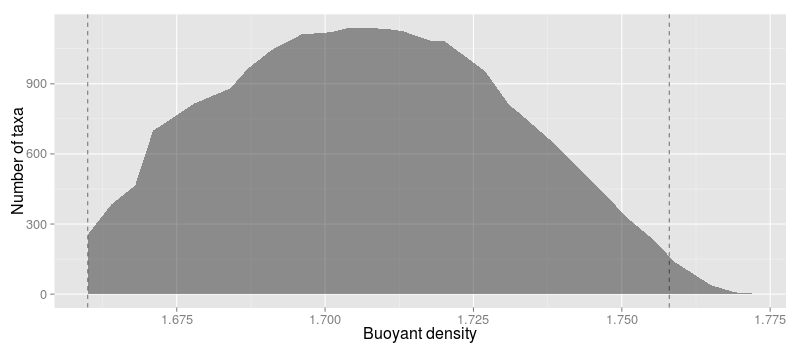

In [71]:
%%R -w 800 -h 350
# plotting number of taxa at each BD

tbl.nt = tbl %>%
    filter(count > 0) %>%
    group_by(BD_min) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(tbl.nt, aes(BD_min, n_taxa)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

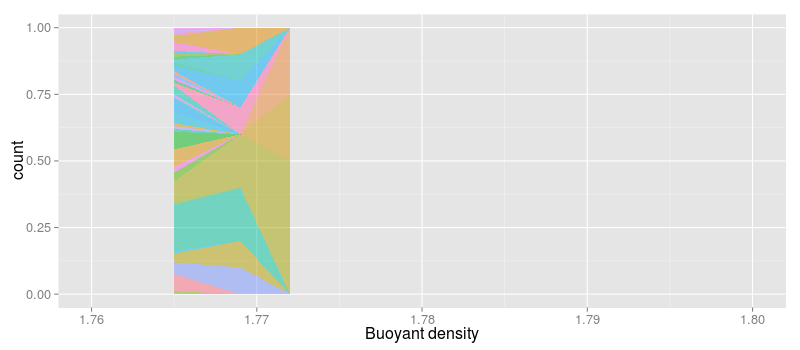

In [72]:
%%R -w 800 -h 350
# plotting rel abunds for just very heavy BD values

BD.low.limit = 1.76
BD.high.limit = 1.8

tbl.heavy = tbl %>%
    filter( BD_min >= BD.low.limit )

tbl.hs = tbl.heavy %>%
    group_by(taxon) %>%
    summarize( total_abund = sum(count) ) %>%
    filter(total_abund > 0)

tbl.heavy = tbl.heavy %>%
    filter(taxon %in% tbl.hs$taxon)


## plot
p = ggplot(tbl.heavy, aes(BD_min, count, fill=taxon, group=taxon)) +
    geom_area(stat='identity', alpha=0.5, position='fill') +
    scale_x_continuous( limits=c(BD.low.limit, BD.high.limit) ) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p


### Most abundant taxa

In [73]:
%%R -i workDir

setwd(workDir)

inFile = 'comm-n1-logn.txt'
tbl.comm = read.delim(inFile, sep='\t')

head(tbl.comm)

  library                          taxon_name rel_abund_perc rank
1       1           Paenibacillus_sabinae_T27       8.163854    1
2       1      Cyclobacterium_marinum_DSM_745       6.440820    2
3       1         Glaciecola_psychrophila_170       3.614699    3
4       1    Listeria_ivanovii_subsp_ivanovii       3.137423    4
5       1 Nitratifractor_salsuginis_DSM_16511       2.571074    5
6       1        Bdellovibrio_bacteriovorus_W       2.507923    6


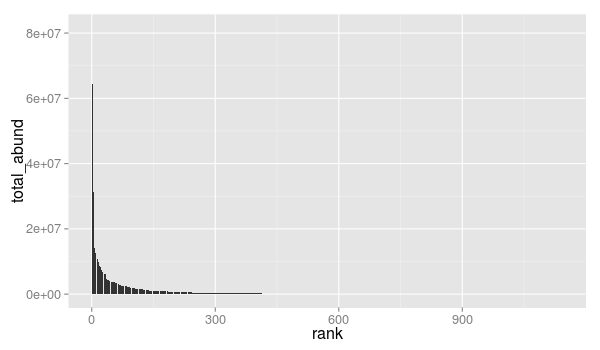

In [74]:
%%R -h 350 -w 600

tbl.s = tbl %>%
    group_by(taxon) %>%
    summarize( total_abund = sum(count) ) %>%
    mutate(rank = min_rank(desc(total_abund))) %>%
    arrange(rank)

ggplot(tbl.s, aes(rank, total_abund)) +
    geom_bar(stat='identity') +
    theme( text = element_text(size=16))

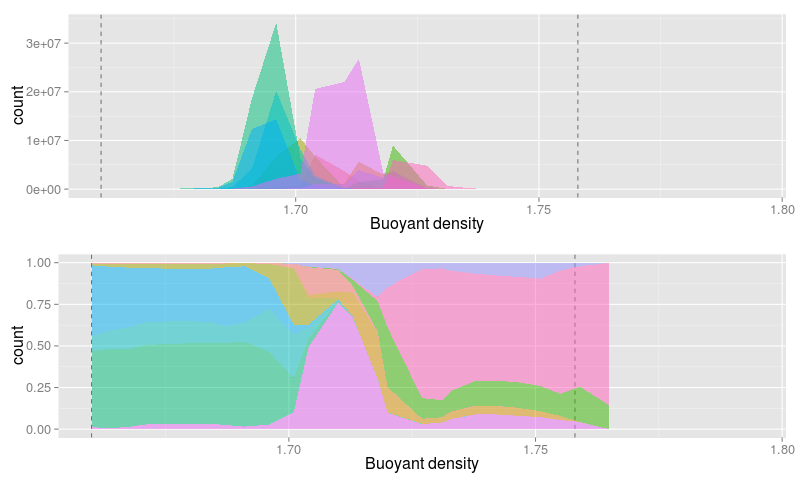

In [75]:
%%R -w 800 
# plotting most abundant taxa

tbl.s.a10 = tbl.s %>%
    filter(rank <= 10)

tbl.a10 = tbl %>%
    filter(taxon %in% tbl.s.a10$taxon)

## plot
p = ggplot(tbl.a10, aes(BD_min, count, fill=taxon, group=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p1 = p + geom_area(stat='identity', alpha=0.5, position='dodge') 
p2 = p + geom_area(stat='identity', alpha=0.5, position='fill') 

grid.arrange(p1, p2, ncol=1)


Call:
lm(formula = BD_range ~ log(total_abund), data = tbl.bdr)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0195330 -0.0044404 -0.0003934  0.0041190  0.0265511 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.0174213  0.0012151   14.34   <2e-16 ***
log(total_abund) 0.0045664  0.0001028   44.42   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.006743 on 1139 degrees of freedom
Multiple R-squared:  0.6341,	Adjusted R-squared:  0.6337 
F-statistic:  1974 on 1 and 1139 DF,  p-value: < 2.2e-16



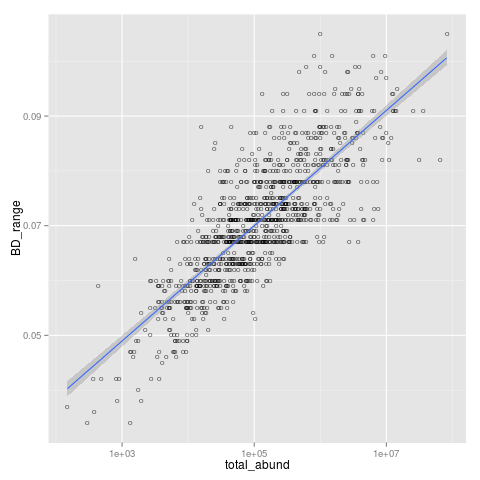

In [76]:
%%R
tbl.bdr = tbl %>%
    group_by(taxon) %>%
    filter(count > 0) %>%
    summarize(BD_range = max(BD_max) - min(BD_min),
              total_abund = sum(count))  

# linear regression
res = lm(BD_range ~ log(total_abund), tbl.bdr)
print(summary(res))

# plotting 
ggplot(tbl.bdr, aes(total_abund, BD_range)) +
    geom_point(alpha=0.75, shape='O') +
    geom_smooth(method='lm') +
    scale_x_log10()

***

## Skewed-normal fragment length distribution 

* default params 
  * I'm explicitly setting the defaults in case they change later
  * no real size restrictions

In [200]:
!cd $workDir;\
    $SIPSimExe fragGC \
    $baseDir/genomes/genome_index.txt \
    --fp $baseDir/genomes/ \
    --fr $baseDir/515Fm-927Rm.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr 500,None \
    --nf 10000 \
    --np 24 \
    2> ampFragGC_skewN90-25-n5-nS.log \
    > ampFragGC_skewN90-25-n5-nS.pkl

## Creating OTU table

In [ ]:
!cd $workDir; \
    $SIPSimExe OTU_sim \
    ampFragGC_skewN90-25-n5-nS.pkl \
    comm-n1-logn.txt \
    incorp-n1-logn.txt \
    fracs-n1-logn.txt \
    --abs_abund 1e9 \
    2> OTU-n1-logn_skewN90-25-n5-nS_A1e9.log \
    > OTU-n1-logn_skewN90-25-n5-nS_A1e9.txt

## Plotting OTU table

In [77]:
%%R -i workDir

# loading file
infile = paste(c(workDir, 'OTU-n1-logn_skewN90-25-n5-nS_A1e9.txt'), collapse='/')
tbl = read.csv(infile, sep='\t')

tbl = tbl %>% 
    separate(fractions, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%
    filter(BD_min != 1.795)

In [78]:
%%R

# summarizing counts (should be approx. total abundance)
tbl %>%
    group_by(library) %>%
    summarize(sum(count))  

Source: local data frame [1 x 2]

  library sum(count)
1       1  946852046


In [79]:
%%R

# summarizing counts (should be approx. total abundance)
tbl %>%
    group_by(BD_min) %>%
    summarize(sum(count)) %>% as.data.frame

   BD_min sum(count)
1   1.660        481
2   1.664       5307
3   1.668      22171
4   1.671     681385
5   1.678   10679770
6   1.684   18692115
7   1.687   43703096
8   1.691  101349768
9   1.696  157278308
10  1.701   76815944
11  1.704  101806150
12  1.710   51613329
13  1.713  101405160
14  1.718   43841423
15  1.720  155395901
16  1.727   58018172
17  1.731   14323573
18  1.733   10607921
19  1.738     578170
20  1.742      30291
21  1.746       3122
22  1.751        372
23  1.755         94
24  1.759         22
25  1.765          0
26  1.769          1
27  1.772          0
28  1.776          0
29  1.778          0
30  1.781          0
31  1.783          0
32  1.788          0
33  1.791          0
34  1.794          0


In [80]:
%%R
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

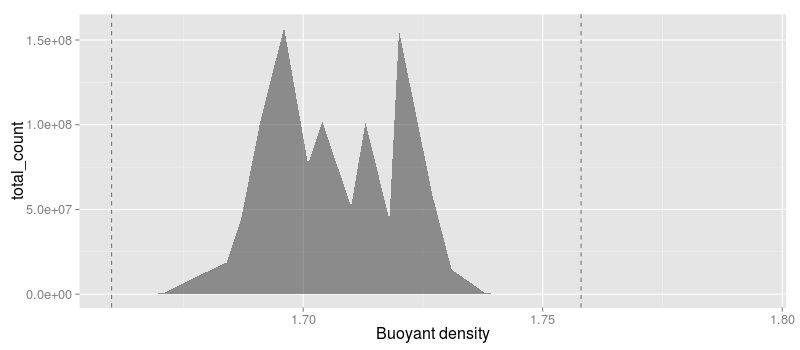

In [81]:
%%R -w 800 -h 350
# plotting absolute abundances

tbl.s = tbl %>%
    group_by(BD_min) %>%
    summarize(total_count = sum(count))


## plot
p = ggplot(tbl.s, aes(BD_min, total_count)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme( 
        text = element_text(size=16) 
    )
p

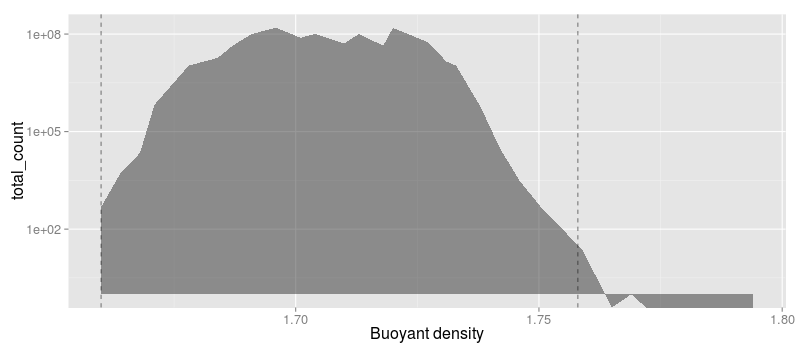

In [82]:
%%R -w 800 -h 350

p + scale_y_log10()

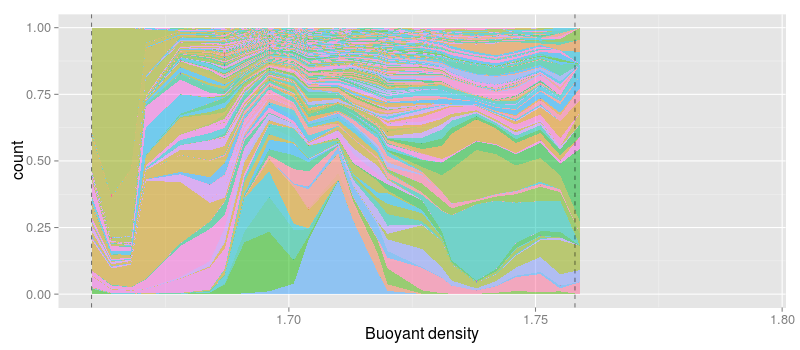

In [83]:
%%R -w 800 -h 350
# plotting relative abundances

## plot
p = ggplot(tbl, aes(BD_min, count, fill=taxon, group=taxon)) +
    geom_area(stat='identity', alpha=0.5, position='fill') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

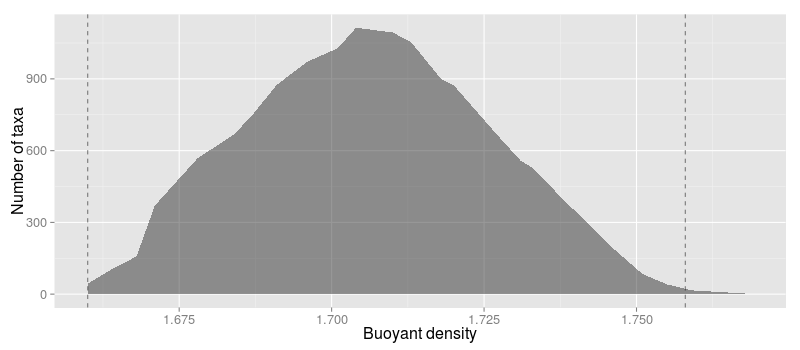

In [84]:
%%R -w 800 -h 350
# plotting number of taxa at each BD

tbl.nt = tbl %>%
    filter(count > 0) %>%
    group_by(BD_min) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(tbl.nt, aes(BD_min, n_taxa)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

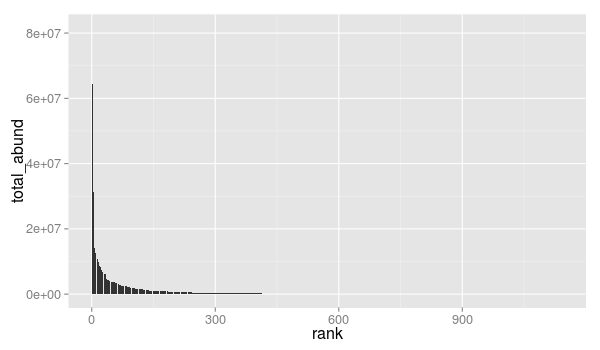

In [85]:
%%R -h 350 -w 600

tbl.s = tbl %>%
    group_by(taxon) %>%
    summarize( total_abund = sum(count) ) %>%
    mutate(rank = min_rank(desc(total_abund))) %>%
    arrange(rank)

ggplot(tbl.s, aes(rank, total_abund)) +
    geom_bar(stat='identity') +
    theme( text = element_text(size=16))

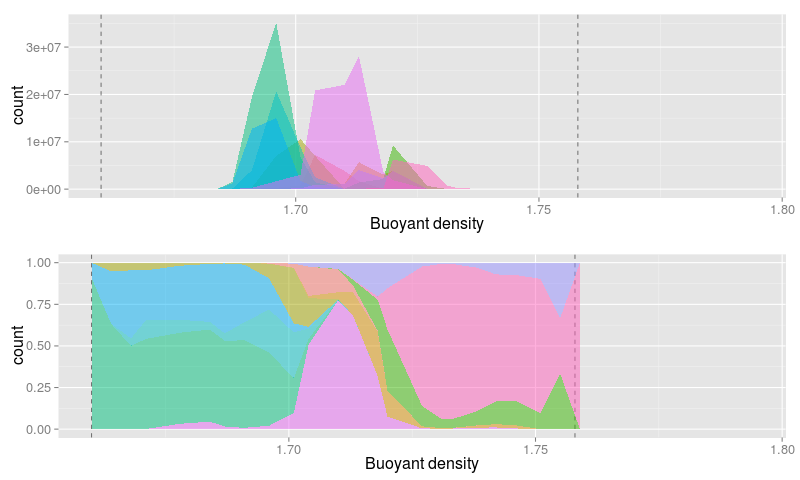

In [86]:
%%R -w 800 
# plotting most abundant taxa

tbl.s.a10 = tbl.s %>%
    filter(rank <= 10)

tbl.a10 = tbl %>%
    filter(taxon %in% tbl.s.a10$taxon)

## plot
p = ggplot(tbl.a10, aes(BD_min, count, fill=taxon, group=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p1 = p + geom_area(stat='identity', alpha=0.5, position='dodge') 
p2 = p + geom_area(stat='identity', alpha=0.5, position='fill') 

grid.arrange(p1, p2, ncol=1)

## Measuring the BD range vs total abundance for each taxon


Call:
lm(formula = BD_range ~ log(total_abund), data = tbl.bdr)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.015380 -0.004478 -0.000374  0.003876  0.020731 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      4.465e-03  1.095e-03   4.078 4.85e-05 ***
log(total_abund) 4.046e-03  9.261e-05  43.689  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.006075 on 1139 degrees of freedom
Multiple R-squared:  0.6263,	Adjusted R-squared:  0.626 
F-statistic:  1909 on 1 and 1139 DF,  p-value: < 2.2e-16



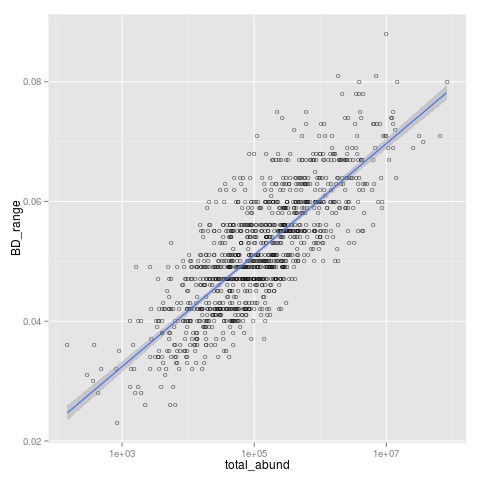

In [87]:
%%R
tbl.bdr = tbl %>%
    group_by(taxon) %>%
    filter(count > 0) %>%
    summarize(BD_range = max(BD_max) - min(BD_min),
              total_abund = sum(count))  

# linear regression
res = lm(BD_range ~ log(total_abund), tbl.bdr)
print(summary(res))

# plotting 
ggplot(tbl.bdr, aes(total_abund, BD_range)) +
    geom_point(alpha=0.75, shape='O') +
    geom_smooth(method='lm') +
    scale_x_log10()

# Subsampling OTU tables

* subsample sizes:
  * 1k
  * 10k
  * 50k

In [88]:
!cd $workDir; \
    SIPSim OTU_subsample \
    OTU-n1-logn_skewN90-25-n5-nS_A1e9.txt \
    --dist_params low:1000,high:1000 \
    > OTU-n1-logn_skewN90-25-n5-nS_A1e9_sub1k.txt

!cd $workDir; \
    SIPSim OTU_subsample \
    OTU-n1-logn_skewN90-25-n5-nS_A1e9.txt \
    --dist_params low:10000,high:10000 \
    > OTU-n1-logn_skewN90-25-n5-nS_A1e9_sub10k.txt
    
!cd $workDir; \
    SIPSim OTU_subsample \
    OTU-n1-logn_skewN90-25-n5-nS_A1e9.txt \
    --dist_params low:50000,high:50000 \
    > OTU-n1-logn_skewN90-25-n5-nS_A1e9_sub50k.txt

In [89]:
%%R -i workDir

# loading file
inFiles = c('OTU-n1-logn_skewN90-25-n5-nS_A1e9_sub1k.txt',
            'OTU-n1-logn_skewN90-25-n5-nS_A1e9_sub10k.txt',
            'OTU-n1-logn_skewN90-25-n5-nS_A1e9_sub50k.txt')

inFiles = sapply(inFiles, function(x){
            paste(c(workDir, x), collapse='/')
    })

tbls = list()
for (fileName in names(inFiles)){
    tbls[[fileName]] = read.csv(fileName, sep='\t')
    }
tbl = do.call(rbind, tbls)
tbl$abs_abund = gsub('.+_sub|\\.txt\\.[0-9]+', '', rownames(tbl))

tbl = tbl %>% 
    separate(fractions, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%
    filter(BD_min != 1.795)

In [90]:
%%R
tax_order = tbl %>%
    group_by(taxon) %>%
    summarize(taxon_total_abund = sum(count)) %>%
    as.data.frame

tax_order = unique(tax_order[order(tax_order$taxon_total_abund, decreasing=T),'taxon']) 

tbl$taxon = factor(tbl$taxon, levels=sort(unique(tbl$taxon), decreasing=T))
tbl$taxon_group = factor(tbl$taxon, levels=tax_order)

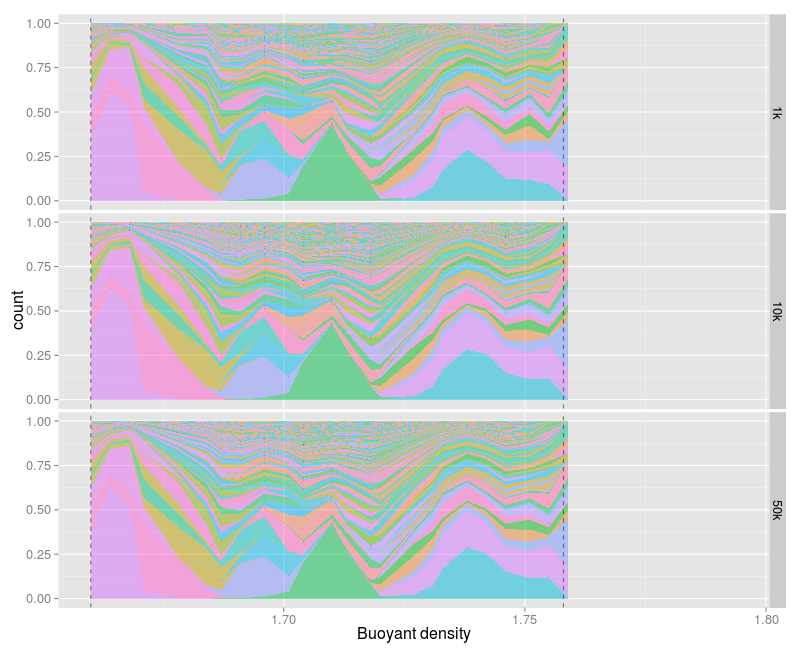

In [91]:
%%R -w 800 -h 650
# plotting abundance

tbl$abs_abund = factor(tbl$abs_abund, levels=c('1k','10k','50k'))

## plot
p = ggplot(tbl, aes(BD_min, count, fill=taxon, order=taxon_group)) +
    geom_area(stat='identity', alpha=0.5, position='fill') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(abs_abund ~ .) +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

Error in layout_base(data, rows, drop = drop) : 
  At least one layer must contain all variables used for facetting
In addition: There were 15 warnings (use warnings() to see them)

Call:
lm(formula = BD_range ~ log(total_abund), data = tbl.bdr)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.037761 -0.005079 -0.001578  0.004469  0.041919 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      6.624e-03  2.623e-04   25.26   <2e-16 ***
log(total_abund) 5.507e-03  6.502e-05   84.70   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.007968 on 2974 degrees of freedom
Multiple R-squared:  0.7069,	Adjusted R-squared:  0.7068 
F-statistic:  7174 on 1 and 2974 DF,  p-value: < 2.2e-16



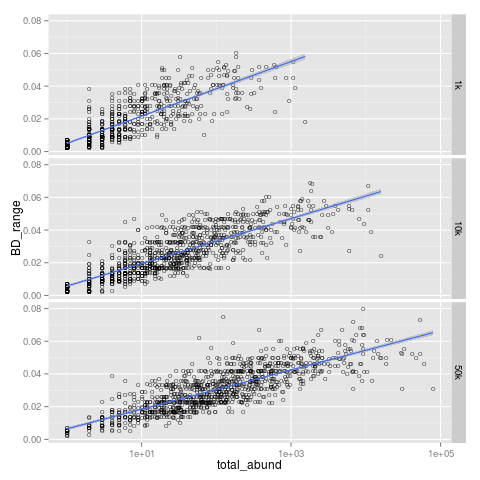

In [94]:
%%R
tbl.bdr = tbl %>%
    group_by(abs_abund, taxon) %>%
    filter(count > 0) %>%
    summarize(BD_range = max(BD_max) - min(BD_min),
              total_abund = sum(count))  

# linear regression
res = lm(BD_range ~ log(total_abund), tbl.bdr)
print(summary(res))

# plotting 
ggplot(tbl.bdr, aes(total_abund, BD_range)) +
    geom_point(alpha=0.75, shape='O') +
    geom_smooth(method='lm') +
    facet_grid(abs_abund ~ .) +
    scale_x_log10()